# West Nile Virus

## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.tools as tls

init_notebook_mode(connected=True)

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
spray = pd.read_csv('../input/spray.csv')
weather = pd.read_csv('../input/weather.csv')

## Data transformation

### Train lite

In [3]:
train_lite = train[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 
                    'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]

In [4]:
train_lite['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Mosquito trap observations are capped at 50 mosquitoes. We need to find multiple trap observations for the same date and group them together. When aggregating species, we'll prioritize `CULEX PIPIENS/RESTUANS`, then `CULEX PIPIENS`, then `CULEX RESTUANS`, and finally other species.

In [5]:
def consolidate_species(series):
    elements = set(series)
    if 'CULEX PIPIENS/RESTUANS' in elements:
        return 'CULEX PIPIENS/RESTUANS'
    elif ('CULEX PIPIENS' in elements) and ('CULEX RESTUANS' in elements):
        return 'CULEX PIPIENS/RESTUANS'
    elif 'CULEX PIPIENS' in elements:
        return 'CULEX PIPIENS'
    elif 'CULEX RESTUANS' in elements:
        return 'CULEX RESTUANS'
    else:
        return 'OTHER'

In [6]:
train_lite = train_lite.groupby(['Date', 'Trap']).agg(
    {
        'Species': consolidate_species,
        'Latitude': np.mean, 
        'Longitude': np.mean,
        'AddressAccuracy': np.mean,
        'NumMosquitos': np.sum, 
        'WnvPresent': np.max,
        'NumMosquitos': np.sum
    }).reset_index()

In [7]:
train_lite.head()

,Date,Trap,Species,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,T002,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,9,2,0
1,2007-05-29,T007,CULEX RESTUANS,41.994991,-87.769279,9,1,0
2,2007-05-29,T015,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,8,5,0
3,2007-05-29,T045,CULEX RESTUANS,41.921600,-87.666455,8,2,0
4,2007-05-29,T046,CULEX RESTUANS,41.891118,-87.654491,8,1,0


In [8]:
train.shape

(10506, 12)

In [9]:
train_lite.shape

(4616, 8)

By merging traps for the same date, we've been able to significantly reduce the number of "superfluous" observations, as well as slightly reduce class imbalance.

In [10]:
train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [11]:
train_lite['WnvPresent'].value_counts(normalize=True)

0    0.916594
1    0.083406
Name: WnvPresent, dtype: float64

We'll also remove `OTHER` species when creating dummy variables.

In [12]:
train_lite['Species'].value_counts()

CULEX PIPIENS/RESTUANS    3876
CULEX RESTUANS             456
CULEX PIPIENS              258
OTHER                       26
Name: Species, dtype: int64

In [13]:
train_lite['CULEX PIPIENS'] = train_lite['Species'].map(
    lambda species: 1 if species in ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS'] else 0)

train_lite['CULEX RESTUANS'] = train_lite['Species'].map(
    lambda species: 1 if species in ['CULEX RESTUANS', 'CULEX PIPIENS/RESTUANS'] else 0)

In [14]:
train_lite.head()

,Date,Trap,Species,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,CULEX PIPIENS,CULEX RESTUANS
0,2007-05-29,T002,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,9,2,0,1,1
1,2007-05-29,T007,CULEX RESTUANS,41.994991,-87.769279,9,1,0,0,1
2,2007-05-29,T015,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,8,5,0,1,1
3,2007-05-29,T045,CULEX RESTUANS,41.921600,-87.666455,8,2,0,0,1
4,2007-05-29,T046,CULEX RESTUANS,41.891118,-87.654491,8,1,0,0,1


Finally, we drop redundant features.

In [15]:
train_lite = train_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude',
                         'NumMosquitos', 'WnvPresent']]

In [16]:
train_lite.head()

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,1,1,41.954690,-87.800991,2,0
1,2007-05-29,0,1,41.994991,-87.769279,1,0
2,2007-05-29,1,1,41.974089,-87.824812,5,0
3,2007-05-29,0,1,41.921600,-87.666455,2,0
4,2007-05-29,0,1,41.891118,-87.654491,1,0


### Adding spray effects

Spraying effectiveness decreases with the inverse square law. We will sum the effects of sprays which are up to 400 meters away, and will only consider a spray's effect for up to 3 days.

In [17]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [18]:
spray['Date'] = pd.to_datetime(spray['Date'])
train_lite['Date'] = pd.to_datetime(train_lite['Date'])

In [19]:
train_lite['Date-1'] = pd.DatetimeIndex(train_lite['Date']) - pd.DateOffset(1)
train_lite['Date-2'] = pd.DatetimeIndex(train_lite['Date']) - pd.DateOffset(2)
train_lite['Date-3'] = pd.DatetimeIndex(train_lite['Date']) - pd.DateOffset(3)

In [20]:
train_lite.head()

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,NumMosquitos,WnvPresent,Date-1,Date-2,Date-3
0,2007-05-29,1,1,41.954690,-87.800991,2,0,2007-05-28,2007-05-27,2007-05-26
1,2007-05-29,0,1,41.994991,-87.769279,1,0,2007-05-28,2007-05-27,2007-05-26
2,2007-05-29,1,1,41.974089,-87.824812,5,0,2007-05-28,2007-05-27,2007-05-26
3,2007-05-29,0,1,41.921600,-87.666455,2,0,2007-05-28,2007-05-27,2007-05-26
4,2007-05-29,0,1,41.891118,-87.654491,1,0,2007-05-28,2007-05-27,2007-05-26


In [21]:
from geopy.distance import geodesic

In [22]:
# Distance in meters from the center of Chicago to 0.005 degrees West
geodesic((41.87, -87.62), (41.87, -87.625)).m

415.09589763727826

In [23]:
train_lite['SprayPowerDay0'] = 0 # sprays on the day of sample collection
train_lite['SprayPowerDay1'] = 0 # sprays on the day before sample collection
train_lite['SprayPowerDay2'] = 0 # sprays two days before sample collection
train_lite['SprayPowerDay3'] = 0 # sprays three days before sample collection

In [24]:
train_lite.head()

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,NumMosquitos,WnvPresent,Date-1,Date-2,Date-3,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3
0,2007-05-29,1,1,41.954690,-87.800991,2,0,2007-05-28,2007-05-27,2007-05-26,0,0,0,0
1,2007-05-29,0,1,41.994991,-87.769279,1,0,2007-05-28,2007-05-27,2007-05-26,0,0,0,0
2,2007-05-29,1,1,41.974089,-87.824812,5,0,2007-05-28,2007-05-27,2007-05-26,0,0,0,0
3,2007-05-29,0,1,41.921600,-87.666455,2,0,2007-05-28,2007-05-27,2007-05-26,0,0,0,0
4,2007-05-29,0,1,41.891118,-87.654491,1,0,2007-05-28,2007-05-27,2007-05-26,0,0,0,0


In [25]:
# calculating spray power for the day of the sample collection
for i in range(train_lite.shape[0]):
    day = train_lite.loc[i, 'Date']
    lat = train_lite.loc[i, 'Latitude']
    long = train_lite.loc[i, 'Longitude']
    
    # create a df for nearby sprays on the same day
    near_sprays_today = spray[
        (spray['Date'] == day)
        # shortcut to reduce comparisons: 0.005 degrees is >= 415 m in Chicago
        & (abs(spray['Latitude'] - lat) < 0.005) 
        & (abs(spray['Longitude'] - long) < 0.005)
    ]
    spray_power = 0
    for j in range(near_sprays_today.shape[0]):
        distance = geodesic(
            (near_sprays_today['Latitude'].iloc[j], near_sprays_today['Longitude'].iloc[j]), 
            (lat, long)
        ).m
        if distance <= 400:
            spray_power += 1/(distance ** 2)
    train_lite.loc[i, 'SprayPowerDay0'] = spray_power

In [26]:
# calculating spray power for the day before the sample collection
for i in range(train_lite.shape[0]):
    day = train_lite.loc[i, 'Date-1']
    lat = train_lite.loc[i, 'Latitude']
    long = train_lite.loc[i, 'Longitude']
    
    # create a df for nearby sprays on the same day
    near_sprays_today = spray[
        (spray['Date'] == day)
        # shortcut to reduce comparisons: 0.005 degrees is >= 415 m in Chicago
        & (abs(spray['Latitude'] - lat) < 0.005) 
        & (abs(spray['Longitude'] - long) < 0.005)
    ]
    spray_power = 0
    for j in range(near_sprays_today.shape[0]):
        distance = geodesic(
            (near_sprays_today['Latitude'].iloc[j], near_sprays_today['Longitude'].iloc[j]), 
            (lat, long)
        ).m
        if distance <= 400:
            spray_power += 1/(distance ** 2)
    train_lite.loc[i, 'SprayPowerDay1'] = spray_power

In [27]:
# calculating spray power for two days before the sample collection
for i in range(train_lite.shape[0]):
    day = train_lite.loc[i, 'Date-2']
    lat = train_lite.loc[i, 'Latitude']
    long = train_lite.loc[i, 'Longitude']
    
    # create a df for nearby sprays on the same day
    near_sprays_today = spray[
        (spray['Date'] == day)
        # shortcut to reduce comparisons: 0.005 degrees is >= 415 m in Chicago
        & (abs(spray['Latitude'] - lat) < 0.005) 
        & (abs(spray['Longitude'] - long) < 0.005)
    ]
    spray_power = 0
    for j in range(near_sprays_today.shape[0]):
        distance = geodesic(
            (near_sprays_today['Latitude'].iloc[j], near_sprays_today['Longitude'].iloc[j]), 
            (lat, long)
        ).m
        if distance <= 400:
            spray_power += 1/(distance ** 2)
    train_lite.loc[i, 'SprayPowerDay2'] = spray_power

In [28]:
# calculating spray power for three days before the sample collection
for i in range(train_lite.shape[0]):
    day = train_lite.loc[i, 'Date-3']
    lat = train_lite.loc[i, 'Latitude']
    long = train_lite.loc[i, 'Longitude']
    
    # create a df for nearby sprays on the same day
    near_sprays_today = spray[
        (spray['Date'] == day)
        # shortcut to reduce comparisons: 0.005 degrees is >= 415 m in Chicago
        & (abs(spray['Latitude'] - lat) < 0.005) 
        & (abs(spray['Longitude'] - long) < 0.005)
    ]
    spray_power = 0
    for j in range(near_sprays_today.shape[0]):
        distance = geodesic(
            (near_sprays_today['Latitude'].iloc[j], near_sprays_today['Longitude'].iloc[j]), 
            (lat, long)
        ).m
        if distance <= 400:
            spray_power += 1/(distance ** 2)
    train_lite.loc[i, 'SprayPowerDay3'] = spray_power

In [29]:
train_lite.head()

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,NumMosquitos,WnvPresent,Date-1,Date-2,Date-3,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3
0,2007-05-29,1,1,41.954690,-87.800991,2,0,2007-05-28,2007-05-27,2007-05-26,0.0,0.0,0.0,0
1,2007-05-29,0,1,41.994991,-87.769279,1,0,2007-05-28,2007-05-27,2007-05-26,0.0,0.0,0.0,0
2,2007-05-29,1,1,41.974089,-87.824812,5,0,2007-05-28,2007-05-27,2007-05-26,0.0,0.0,0.0,0
3,2007-05-29,0,1,41.921600,-87.666455,2,0,2007-05-28,2007-05-27,2007-05-26,0.0,0.0,0.0,0
4,2007-05-29,0,1,41.891118,-87.654491,1,0,2007-05-28,2007-05-27,2007-05-26,0.0,0.0,0.0,0


In [30]:
train_lite = train_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude',
                         'SprayPowerDay0', 'SprayPowerDay1', 'SprayPowerDay2', 'SprayPowerDay3',
                         'NumMosquitos', 'WnvPresent']]

In [31]:
train_lite.head()

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3,NumMosquitos,WnvPresent
0,2007-05-29,1,1,41.954690,-87.800991,0.0,0.0,0.0,0,2,0
1,2007-05-29,0,1,41.994991,-87.769279,0.0,0.0,0.0,0,1,0
2,2007-05-29,1,1,41.974089,-87.824812,0.0,0.0,0.0,0,5,0
3,2007-05-29,0,1,41.921600,-87.666455,0.0,0.0,0.0,0,2,0
4,2007-05-29,0,1,41.891118,-87.654491,0.0,0.0,0.0,0,1,0


### Weather transform

In [32]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [33]:
weather_lite = pd.DataFrame([], columns=weather.columns)

for i in range(int(weather.shape[0]/2)):
    row = []
    for col in weather_lite.columns:
        if col in ['Station', 'Date', 'Sunrise', 'Sunset']:
            row.append(weather[col].loc[(2*i)])
        else:
            try:
                val = (float(weather[col].loc[(2*i)]) + float(weather[col].loc[(2*i+1)]))/2
            except ValueError:
                try:
                    val = float(weather[col].loc[(2*i)])
                except ValueError:
                    try:
                        val = float(weather[col].loc[(2*i+1)])
                    except ValueError:
                        val = str(weather[col].loc[(2*i)]) + ' ' + weather[col].loc[(2*i+1)]
            row.append(val)
    weather_lite.loc[i] = row

In [34]:
def string_to_hours(string):
    return int(string[0:2]) + int(string[3:4])/60

weather_lite['SunshineHours'] = weather_lite['Sunset'].map(string_to_hours) - weather_lite['Sunrise'].map(string_to_hours)

In [35]:
weather_lite = weather_lite[['Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 
                             'Heat', 'Cool', 'SunshineHours', 'Depth', 'SeaLevel', 'AvgSpeed']]

In [36]:
weather_lite.dtypes

Date             datetime64[ns]
Tmax                    float64
Tmin                    float64
Tavg                    float64
Depart                  float64
DewPoint                float64
WetBulb                 float64
Heat                    float64
Cool                    float64
SunshineHours           float64
Depth                   float64
SeaLevel                float64
AvgSpeed                float64
dtype: object

### Train and weather merge

In [37]:
train_weather = pd.merge(train_lite, weather_lite, how='left', left_on='Date', right_on='Date')

In [38]:
with pd.option_context('display.max_columns', None):
    display(train_weather.head())

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SunshineHours,Depth,SeaLevel,AvgSpeed
0,2007-05-29,1,1,41.954690,-87.800991,0.0,0.0,0.0,0,2,0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,15.1,0.0,30.1,6.95
1,2007-05-29,0,1,41.994991,-87.769279,0.0,0.0,0.0,0,1,0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,15.1,0.0,30.1,6.95
2,2007-05-29,1,1,41.974089,-87.824812,0.0,0.0,0.0,0,5,0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,15.1,0.0,30.1,6.95
3,2007-05-29,0,1,41.921600,-87.666455,0.0,0.0,0.0,0,2,0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,15.1,0.0,30.1,6.95
4,2007-05-29,0,1,41.891118,-87.654491,0.0,0.0,0.0,0,1,0,88.0,62.5,75.5,10.0,58.5,65.5,0.0,10.5,15.1,0.0,30.1,6.95


In [39]:
train_weather['Date'] = pd.to_datetime(train_weather['Date'], utc=True)

In [40]:
train_weather.to_csv('./../input/transformed_input/train_weather.csv')

### Test transform

In [41]:
test_lite = test[['Date', 'Species', 'Latitude', 'Longitude']]

test_lite['CULEX PIPIENS'] = test_lite['Species'].map(
    lambda species: 1 if species in ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS'] else 0)

test_lite['CULEX RESTUANS'] = test_lite['Species'].map(
    lambda species: 1 if species in ['CULEX RESTUANS', 'CULEX PIPIENS/RESTUANS'] else 0)

test_lite = test_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [42]:
test_lite['Date'] = pd.to_datetime(test_lite['Date'])

In [43]:
test_lite['Date-1'] = pd.DatetimeIndex(test_lite['Date']) - pd.DateOffset(1)
test_lite['Date-2'] = pd.DatetimeIndex(test_lite['Date']) - pd.DateOffset(2)
test_lite['Date-3'] = pd.DatetimeIndex(test_lite['Date']) - pd.DateOffset(3)

In [44]:
test_lite['SprayPowerDay0'] = 0 # sprays on the day of sample collection
test_lite['SprayPowerDay1'] = 0 # sprays on the day before sample collection
test_lite['SprayPowerDay2'] = 0 # sprays two days before sample collection
test_lite['SprayPowerDay3'] = 0 # sprays three days before sample collection

In [45]:
test_lite = test_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude',
                       'SprayPowerDay0', 'SprayPowerDay1', 'SprayPowerDay2', 'SprayPowerDay3']]

In [46]:
test_weather = pd.merge(test_lite, weather_lite, how='left', left_on='Date', right_on='Date')

In [47]:
with pd.option_context('display.max_columns', None):
    display(test_weather.head())

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SunshineHours,Depth,SeaLevel,AvgSpeed
0,2008-06-11,1,1,41.95469,-87.800991,0,0,0,0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,15.0,0.0,29.98,10.2
1,2008-06-11,0,1,41.95469,-87.800991,0,0,0,0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,15.0,0.0,29.98,10.2
2,2008-06-11,1,0,41.95469,-87.800991,0,0,0,0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,15.0,0.0,29.98,10.2
3,2008-06-11,0,0,41.95469,-87.800991,0,0,0,0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,15.0,0.0,29.98,10.2
4,2008-06-11,0,0,41.95469,-87.800991,0,0,0,0,86.0,63.5,75.0,7.0,55.5,64.0,0.0,10.0,15.0,0.0,29.98,10.2


In [48]:
test_weather['Date'] = pd.to_datetime(test_weather['Date'], utc=True)

In [49]:
test_weather.to_csv('./../input/transformed_input/test_weather.csv')

# Train test split

In [50]:
from sklearn.model_selection import train_test_split

We remove `NumMosquitos`, since it is not available in the test data.

In [104]:
X = train_weather.drop(columns='WnvPresent')
y = train_weather['WnvPresent']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=437708)

In [106]:
X_train.head()

,Date,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3,NumMosquitos,...,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,SunshineHours,Depth,SeaLevel,AvgSpeed
3236,2011-09-12 00:00:00+00:00,1,1,41.763733,-87.742302,0.0,0.0,0.0,0,5,...,75.0,10.0,59.0,65.0,0.0,10.0,13.016667,0.0,29.905,10.10
2732,2011-07-15 00:00:00+00:00,0,1,41.986921,-87.689778,0.0,0.0,0.0,0,1,...,79.0,5.0,60.0,66.5,0.0,14.0,14.950000,0.0,29.970,6.75
444,2007-08-01 00:00:00+00:00,1,1,41.747850,-87.702716,0.0,0.0,0.0,0,7,...,80.5,8.0,62.5,69.5,0.0,15.5,14.933333,0.0,29.990,3.90
448,2007-08-01 00:00:00+00:00,1,1,41.778748,-87.586427,0.0,0.0,0.0,0,12,...,80.5,8.0,62.5,69.5,0.0,15.5,14.933333,0.0,29.990,3.90
2603,2011-06-24 00:00:00+00:00,1,1,41.974689,-87.890615,0.0,0.0,0.0,0,130,...,64.0,-7.0,55.5,59.0,1.0,0.0,14.900000,0.0,29.760,9.15


In [107]:
y_train_mosq = X_train['NumMosquitos']
y_test_mosq = X_test['NumMosquitos']
X_train.drop(columns='NumMosquitos', inplace=True)
X_test.drop(columns='NumMosquitos', inplace=True)

## Logistic regression

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
logr = LogisticRegression()

In [56]:
X_train_dates = X_train.copy()
X_train_dates.loc[:, 'Year'] = X_train_dates['Date'].dt.year
X_train_dates.loc[:, 'Month'] = X_train_dates['Date'].dt.month
X_train_dates.loc[:, 'Day'] = X_train_dates['Date'].dt.day
X_train_dates.drop(columns='Date', inplace=True)

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
ss = StandardScaler()

In [59]:
ss.fit(X_train_dates)

X_train_dates = pd.DataFrame(ss.transform(X_train_dates), columns=X_train_dates.columns)

In [60]:
logr.fit(X_train_dates, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
logr.score(X_train_dates, y_train)

0.9170999422299249

In [96]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, logr.predict_proba(X_train_dates)[:,1], pos_label=1)
auc(fpr, tpr)

0.8235534031190941

In [97]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, logr.predict_proba(X_test_dates)[:,1], pos_label=1)
auc(fpr, tpr)

0.7879548676748582

In [62]:
X_test_dates = X_test.copy()
X_test_dates.loc[:, 'Year'] = X_test_dates['Date'].dt.year
X_test_dates.loc[:, 'Month'] = X_test_dates['Date'].dt.month
X_test_dates.loc[:, 'Day'] = X_test_dates['Date'].dt.day
X_test_dates.drop(columns='Date', inplace=True)

In [63]:
X_test_dates = pd.DataFrame(ss.transform(X_test_dates), columns=X_test_dates.columns)

In [64]:
logr.score(X_test_dates, y_test)

0.9150779896013865

In [65]:
list(zip(X_test_dates.columns, logr.coef_[0]))

[('CULEX PIPIENS', 0.9325369878398946),
 ('CULEX RESTUANS', 0.18163493280940238),
 ('Latitude', -0.1273664559076738),
 ('Longitude', -0.49519244779273297),
 ('SprayPowerDay0', 0.02086492579300596),
 ('SprayPowerDay1', 0.12895426508991092),
 ('SprayPowerDay2', 0.007737364448351738),
 ('SprayPowerDay3', 0.0),
 ('Tmax', 0.7291613445441494),
 ('Tmin', 0.799492391696547),
 ('Tavg', 0.6150529050002451),
 ('Depart', -2.3398271561759243),
 ('DewPoint', 0.4024883142066001),
 ('WetBulb', -0.18453855556712231),
 ('Heat', -0.26080655215591225),
 ('Cool', 0.6920711540167542),
 ('SunshineHours', -0.5276370091288546),
 ('Depth', 0.0),
 ('SeaLevel', 0.04288256268556089),
 ('AvgSpeed', 0.01416928972576071),
 ('Year', 0.31458288137788665),
 ('Month', 1.8829550419357342),
 ('Day', 0.2059457739388218)]

In [66]:
logr.predict_proba(X_test_dates)

array([[8.62082460e-01, 1.37917540e-01],
       [8.44650100e-01, 1.55349900e-01],
       [9.20451972e-01, 7.95480282e-02],
       ...,
       [8.62748175e-01, 1.37251825e-01],
       [9.99979997e-01, 2.00033292e-05],
       [8.17106264e-01, 1.82893736e-01]])

In [67]:
test_weather_dates = test_weather.copy()
test_weather_dates.loc[:, 'Year'] = test_weather_dates['Date'].dt.year
test_weather_dates.loc[:, 'Month'] = test_weather_dates['Date'].dt.month
test_weather_dates.loc[:, 'Day'] = test_weather_dates['Date'].dt.day
test_weather_dates.drop(columns='Date', inplace=True)

In [70]:
test_weather_dates = pd.DataFrame(ss.transform(test_weather_dates), columns=test_weather_dates.columns)

In [73]:
test_weather_dates.head()

,CULEX PIPIENS,CULEX RESTUANS,Latitude,Longitude,SprayPowerDay0,SprayPowerDay1,SprayPowerDay2,SprayPowerDay3,Tmax,Tmin,...,WetBulb,Heat,Cool,SunshineHours,Depth,SeaLevel,AvgSpeed,Year,Month,Day
0,0.327309,0.262390,1.010615,-1.311931,-0.020522,-0.016998,-0.02392,0.0,0.582272,0.106251,...,-0.009875,-0.371448,0.317182,0.884687,0.0,0.138948,1.046489,-0.770101,-1.479914,-0.549415
1,-3.055213,0.262390,1.010615,-1.311931,-0.020522,-0.016998,-0.02392,0.0,0.582272,0.106251,...,-0.009875,-0.371448,0.317182,0.884687,0.0,0.138948,1.046489,-0.770101,-1.479914,-0.549415
2,0.327309,-3.811124,1.010615,-1.311931,-0.020522,-0.016998,-0.02392,0.0,0.582272,0.106251,...,-0.009875,-0.371448,0.317182,0.884687,0.0,0.138948,1.046489,-0.770101,-1.479914,-0.549415
3,-3.055213,-3.811124,1.010615,-1.311931,-0.020522,-0.016998,-0.02392,0.0,0.582272,0.106251,...,-0.009875,-0.371448,0.317182,0.884687,0.0,0.138948,1.046489,-0.770101,-1.479914,-0.549415
4,-3.055213,-3.811124,1.010615,-1.311931,-0.020522,-0.016998,-0.02392,0.0,0.582272,0.106251,...,-0.009875,-0.371448,0.317182,0.884687,0.0,0.138948,1.046489,-0.770101,-1.479914,-0.549415


In [83]:
predictions = pd.DataFrame(logr.predict_proba(test_weather_dates)[:,1], 
                        index=test_weather_dates.index,
                        columns=['WnvPresent'])

In [90]:
predictions['Id'] = test['Id']
predictions = predictions[['Id', 'WnvPresent']]
predictions.head()

,Id,WnvPresent
0,1,0.000859
1,2,0.000037
2,3,0.000410
3,4,0.000018
4,5,0.000018


In [92]:
predictions.to_csv('./../submissions/submission01-martim.csv', index=False)

## Logistic regression on the number of mosquitoes

In [116]:
logr.fit(X_train_dates, y_train_mosq)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
logr.score(X_train_dates, y_train_mosq)

0.15800115540150203

In [117]:
logr.score(X_test_dates, y_test_mosq)

0.15077989601386482

In [119]:
list(zip(X_test_dates.columns, logr.coef_[0]))

[('CULEX PIPIENS', -0.604609343169971),
 ('CULEX RESTUANS', -0.4332578918812502),
 ('Latitude', 0.240627305876157),
 ('Longitude', 0.2996344774885148),
 ('SprayPowerDay0', -0.2217928016953901),
 ('SprayPowerDay1', -0.05270086838602226),
 ('SprayPowerDay2', -0.14116840342063255),
 ('SprayPowerDay3', 0.0),
 ('Tmax', 0.05705337287847954),
 ('Tmin', -0.08298315492844494),
 ('Tavg', -0.24449445684867893),
 ('Depart', 0.031900362161254525),
 ('DewPoint', -0.1282112728935803),
 ('WetBulb', 0.33633777450763125),
 ('Heat', 0.14937467335305485),
 ('Cool', -0.251681932048036),
 ('SunshineHours', 0.15356167635230628),
 ('Depth', 0.0),
 ('SeaLevel', -0.014744756061638813),
 ('AvgSpeed', 0.06795787163730091),
 ('Year', -0.37384163990405866),
 ('Month', 0.03277248218708665),
 ('Day', 0.26489959350421416)]

### Gradient boosting classifier

In [126]:
from sklearn.ensemble import GradientBoostingClassifier

In [127]:
gbc = GradientBoostingClassifier()

In [128]:
gbc.fit(X_train_dates, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [129]:
gbc.score(X_train_dates, y_train)

0.9324090121317158

In [130]:
gbr.predict(X_train_dates)

array([ 0.1291978 ,  0.00718277,  0.0775725 , ..., -0.03214785,
        0.01110952, -0.00676805])

In [131]:
gbc.score(X_test_dates, y_test)

0.9185441941074524

### Random forest classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [148]:
rfc = RandomForestClassifier(random_state=437708)

In [149]:
rfc.fit(X_train_dates, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=437708, verbose=0,
            warm_start=False)

In [150]:
rfc.score(X_train_dates, y_train)

0.9867128827267475

In [151]:
rfc.score(X_test_dates, y_test)

0.902946273830156

In [155]:
rfc_predictions = pd.DataFrame(rfc.predict_proba(test_weather_dates)[:,1],
                               index=test_weather_dates.index,
                               columns=['WnvPresent'])

In [156]:
rfc_predictions['Id'] = test['Id']
rfc_predictions = rfc_predictions[['Id', 'WnvPresent']]
rfc_predictions.head()

,Id,WnvPresent
0,1,0.1
1,2,0.1
2,3,0.1
3,4,0.1
4,5,0.1


In [157]:
rfc_predictions.to_csv('./../submissions/submission02-martim.csv', index=False)

## Bunch of 💩 below here

In [ ]:
test_lite.head()

### Transforming `Date` to `datetime` objects with time

In [ ]:
train['Date'] = pd.to_datetime(train['Date'], utc=True)

In [ ]:
spray['Date'] = pd.to_datetime(spray['Date'] + ' ' + spray['Time'], utc=True)

In [ ]:
weather['Date'] = pd.to_datetime(weather['Date'], utc=True)

In [ ]:
weather.head()

In [ ]:
def weather_lat_long_elev(station):
    if station == 1:
        return (41.995, -87.933, 662)
    elif station == 2:
        return (41.786, -87.752, 612)
    
def weather_lat(station):
    if station == 1:
        return 41.995
    elif station == 2:
        return 41.786
    
def weather_long(station):
    if station == 1:
        return -87.933
    elif station == 2:
        return -87.752
    
def weather_elev(station):
    if station == 1:
        return 662
    elif station == 2:
        return 612

In [ ]:
weather['Latitude'] = weather['Station'].apply(weather_lat)
weather['Longitude'] = weather['Station'].apply(weather_long)

In [ ]:
weather.head()

In [ ]:
spray.head()

In [ ]:
train.head()

In [ ]:
weather.head()

### Train lite

In [ ]:
train_lite = train[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 
                    'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]

In [ ]:
train_lite['Species'].value_counts()

Mosquito trap observations are capped at 50 mosquitoes. We need to find multiple trap observations for the same date and group them together. When aggregating species, we'll prioritize `CULEX PIPIENS/RESTUANS`, then `CULEX PIPIENS`, then `CULEX RESTUANS`, and finally other species.

In [ ]:
def consolidate_species(series):
    elements = set(series)
    if 'CULEX PIPIENS/RESTUANS' in elements:
        return 'CULEX PIPIENS/RESTUANS'
    elif ('CULEX PIPIENS' in elements) and ('CULEX RESTUANS' in elements):
        return 'CULEX PIPIENS/RESTUANS'
    elif 'CULEX PIPIENS' in elements:
        return 'CULEX PIPIENS'
    elif 'CULEX RESTUANS' in elements:
        return 'CULEX RESTUANS'
    else:
        return 'OTHER'

In [ ]:
train_lite = train_lite.groupby(['Date', 'Trap']).agg(
    {
        'Species': consolidate_species,
        'Latitude': np.mean, 
        'Longitude': np.mean,
        'AddressAccuracy': np.mean,
        'NumMosquitos': np.sum, 
        'WnvPresent': np.max,
        'NumMosquitos': np.sum
    }).reset_index()

In [ ]:
train_lite.head()

In [ ]:
train.shape

In [ ]:
train_lite.shape

By merging traps for the same date, we've been able to significantly reduce the number of "superfluous" observations, as well as slightly reduce class imbalance.

In [ ]:
train['WnvPresent'].value_counts(normalize=True)

In [ ]:
train_lite['WnvPresent'].value_counts(normalize=True)

We'll also remove `OTHER` species when creating dummy variables.

In [ ]:
train_lite['Species'].value_counts()

In [ ]:
train_lite['CULEX PIPIENS'] = train_lite['Species'].map(
    lambda species: 1 if species in ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS'] else 0)

train_lite['CULEX RESTUANS'] = train_lite['Species'].map(
    lambda species: 1 if species in ['CULEX RESTUANS', 'CULEX PIPIENS/RESTUANS'] else 0)

In [ ]:
train_lite.head()

Finally, we drop redundant features, as well as remove `NumMosquitos`, since it is not available in the test data.

In [ ]:
train_lite = train_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude', 'WnvPresent']]

In [ ]:
train_lite.head()

### Adding spray effects

Spraying effectiveness decreases with the inverse square law. We will sum the effects of sprays which are up to 400 meters away, and will only consider a spray's effect for up to 3 days.

In [ ]:
spray['Date'] = pd.to_datetime(spray['Date'])
train_lite['Date'] = pd.to_datetime(train_lite['Date'])

In [ ]:
train_lite['Date-1'] = pd.DatetimeIndex(train_lite['Date']) - pd.DateOffset(1)
train_lite['Date-2'] = pd.DatetimeIndex(train_lite['Date']) - pd.DateOffset(2)
train_lite['Date-3'] = pd.DatetimeIndex(train_lite['Date']) - pd.DateOffset(3)

In [ ]:
train_lite.head()

In [ ]:
from geopy.distance import geodesic

In [ ]:
spray['Date'].value_counts()

In [ ]:
geodesic((41.87, -87.62), (41.87, -87.625)).m

In [ ]:
geopy.distance.geodesic((41.87, -87.62), (41.87, -87.625)).m

In [ ]:
for 

In [ ]:
spray[(spray['Date'] == '2013-08-15') 
      & (abs(spray['Latitude'] - 41.944718) < 0.005)
      & (abs(spray['Longitude'] - (-87.808187)) < 0.005)].shape

In [ ]:
near_sprays_today = spray[
    (spray['Date'] == '2013-08-15')
    & (abs(spray['Latitude'] - 41.944718) < 0.005)
    & (abs(spray['Longitude'] - (-87.808187)) < 0.005)
]

In [ ]:
train_lite['SprayPowerToday'] = 0

In [ ]:
train_lite.loc['SprayPowerToday',0] = 3

In [ ]:
train_lite.drop('SprayPowerToday', inplace=True)

In [ ]:
train_lite.head()

In [ ]:
for i in range(train_lite.head().shape[0]):
    day = train_lite['Date'].loc[i]
    lat = train_lite['Latitude'].loc[i]
    long = train_lite['Longitude'].loc[i]
    near_sprays_today = spray[
        (spray['Date'] == day)
        & (abs(spray['Latitude'] - lat) < 0.005)
        & (abs(spray['Longitude'] - long) < 0.005)
    ]
    spray_power = 0
    for j in range(near_sprays_today.shape[0]):
        distance = geodesic(
            (near_sprays_today['Latitude'].loc[j], near_sprays_today['Longitude'].loc[j]), 
            (lat, long)
        ).m
        if distance <= 400:
            spray_power += 1/(distance ** 2)
    train

In [ ]:
train_lite['Date'] = pd.to_datetime(train_lite['Date'])

In [ ]:
spray['Date'].dt.mktime()

In [ ]:
dt.timedelta(spray['Date'].loc[0], 
             dt.date(2007,5,28))

In [ ]:
spray[dt.timedelta(spray['Date'], dt.date(2007,5,28)) == 1]

In [ ]:
spray[spray['Latitude'] - 41 > 0]

In [ ]:
geopy.distance.geodesic((41.87, -87.62), (41.87, -87.63)).m

In [ ]:
train_lite.head()

In [ ]:
41.8781, -87.629841

In [ ]:
spray.head()

In [ ]:
import geopy.distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

geopy.distance.vincenty(coords_1, coords_2).km

geopy.distance.geodesic(coords_1, coords_2).m

In [ ]:
geopy.distance.geodesic((spray['Latitude'].loc[0], spray['Longitude'].loc[0]), (spray['Latitude'].loc[1], spray['Longitude'].loc[1])).m

In [ ]:
spray['Date'].value_counts()

In [ ]:
spray.head()

### Weather transform

In [ ]:
weather_lite = pd.DataFrame([], columns=weather.columns)

for i in range(int(weather.shape[0]/2)):
    row = []
    for col in weather_lite.columns:
        if col in ['Station', 'Date', 'Sunrise', 'Sunset']:
            row.append(weather[col].loc[(2*i)])
        else:
            try:
                val = (float(weather[col].loc[(2*i)]) + float(weather[col].loc[(2*i+1)]))/2
            except ValueError:
                try:
                    val = float(weather[col].loc[(2*i)])
                except ValueError:
                    try:
                        val = float(weather[col].loc[(2*i+1)])
                    except ValueError:
                        val = str(weather[col].loc[(2*i)]) + ' ' + weather[col].loc[(2*i+1)]
            row.append(val)
    weather_lite.loc[i] = row

In [ ]:
def string_to_hours(string):
    return int(string[0:2]) + int(string[3:4])/60

weather_lite['SunshineHours'] = weather_lite['Sunset'].map(string_to_hours) - weather_lite['Sunrise'].map(string_to_hours)

In [ ]:
weather_lite = weather_lite[['Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 
                             'Heat', 'Cool', 'SunshineHours', 'Depth', 'SeaLevel', 'AvgSpeed']]

In [ ]:
weather_lite.dtypes

### Train and weather merge

In [ ]:
train_weather = pd.merge(train_lite, weather_lite, how='left', left_on='Date', right_on='Date')

In [ ]:
train_weather.head()

In [ ]:
train_weather.to_csv('./../input/transformed_input/train_weather.csv')

### Test transform

In [ ]:
test_lite = test[['Date', 'Species', 'Latitude', 'Longitude']]

test_lite['CULEX PIPIENS'] = test_lite['Species'].map(
    lambda species: 1 if species in ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS'] else 0)

test_lite['CULEX RESTUANS'] = test_lite['Species'].map(
    lambda species: 1 if species in ['CULEX RESTUANS', 'CULEX PIPIENS/RESTUANS'] else 0)

test_lite = test_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude']]

In [ ]:
test_weather = pd.merge(test_lite, weather_lite, how='left', left_on='Date', right_on='Date')

In [ ]:
test_weather.head()

In [ ]:
train[['Trap', 'Latitude', 'Longitude']].groupby('Trap').agg(
    {'Latitude': pd.Series.nunique, 
     'Longitude': pd.Series.nunique}).sort_values('Latitude', ascending=False)

In [ ]:
train_lite = train_lite[['Date', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Latitude', 'Longitude',
                         'NumMosquitos', 'WnvPresent']]

In [ ]:
train_lite.head()

In [ ]:
with pd.option_context('display.max_columns', None):
    display(weather.head())

In [ ]:
weather.iloc[0]

In [ ]:
weather.shape

In [ ]:
weather['Date'].loc[3]

In [ ]:
weather_lite.loc[0]['Date']

In [ ]:
val = int(weather['Depart'].loc[1])

In [ ]:
try:
    val = (float(weather['Depart'].loc[1]) + float(weather['Depart'].loc[3]))/2
except ValueError:
    try:
        val = float(weather['Depart'].loc[1])
    except ValueError:
        try:
            val = float(weather['Depart'].loc[3])
        except ValueError:
            val = str(weather['Depart'].loc[1]) + ' ' + weather['Depart'].loc[3]
    
val

In [ ]:
val

In [ ]:
spray.head()

### Weather transform

In [ ]:
weather_lite = pd.DataFrame([], columns=weather.columns)

for i in range(int(weather.shape[0]/2)):
    row = []
    for col in weather_lite.columns:
        if col in ['Station', 'Date', 'Sunrise', 'Sunset']:
            row.append(weather[col].loc[(2*i)])
        else:
            try:
                val = (float(weather[col].loc[(2*i)]) + float(weather[col].loc[(2*i+1)]))/2
            except ValueError:
                try:
                    val = float(weather[col].loc[(2*i)])
                except ValueError:
                    try:
                        val = float(weather[col].loc[(2*i+1)])
                    except ValueError:
                        val = str(weather[col].loc[(2*i)]) + ' ' + weather[col].loc[(2*i+1)]
            row.append(val)
    weather_lite.loc[i] = row

In [ ]:
def string_to_hours(string):
    return int(string[0:2]) + int(string[3:4])/60

weather_lite['SunshineHours'] = weather_lite['Sunset'].map(string_to_hours) - weather_lite['Sunrise'].map(string_to_hours)

In [ ]:
weather_lite = weather_lite[['Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 
                             'Heat', 'Cool', 'SunshineHours', 'Depth', 'SeaLevel', 'ResultSpeed',
                             'ResultDir', 'AvgSpeed', 'Latitude', 'Longitude']]

In [ ]:
weather_lite.dtypes

In [ ]:
train_lite.dtypes

In [ ]:
train_lite['Species'].value_counts()

In [ ]:
weather.head()

In [ ]:
with pd.option_context('display.max_columns', None):
    display(weather_lite.head())

In [ ]:
weather_lite.dtypes

In [ ]:
pd.merge(train, weather, how='left', left_on='Date', right_on='Date')[['Station']]

In [ ]:
train['AddressAccuracy'].value_counts()

In [ ]:
spray.to_csv('./../input/transformed_input/spray_clean.csv')

In [ ]:
train.to_csv('./../input/transformed_input/train_clean.csv')

In [ ]:
weather.to_csv('./../input/transformed_input/weather_clean.csv')

In [ ]:
train[train['WnvPresent'] == 1].shape

In [ ]:
train.shape

In [ ]:
from datetime import date
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def year_fraction(birthday):
    start = date(birthday.year, 1, 1).toordinal()
    year_length = date(birthday.year+1, 1, 1).toordinal() - start
    fractional_year = birthday.year + float(birthday.toordinal() - start) / year_length
    return fractional_year

data = [19900806, 19780517, 19900215, 19841102, 19800709, 19870421, 19780905, 19900111, 19950702, 19921009, 19930612, 19930131, 19870109]
birthdates = list()

for birthdate in data:
    datestr = str(birthdate)
    datestr = int(datestr[0:4]), int(datestr[4:6]), int(datestr[6:8])
    birthdates.append(date(datestr[0], datestr[1], datestr[2]))

birthdates = pd.Series(birthdates, name='birthdates')
birthdates = birthdates.apply(year_fraction)
sns.stripplot(x=birthdates);

In [ ]:
train.shape[0]

In [ ]:
plt.plot(range(1, train.shape[0]+1), pd.to_datetime(train['Date']), 'ro')

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(pd.to_datetime(train['Date']), [1] * train.shape[0], 'rx')
plt.plot(pd.to_datetime(train['Date']), train['WnvPresent'], 'bx');

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(pd.to_datetime(test['Date']), [1] * test.shape[0], 'rx');
plt.plot(pd.to_datetime(spray['Date']), [1] * spray.shape[0], 'bx');

In [ ]:
train[train['WnvPresent'] == 1]['Date'].map(lambda date_str: int(date_str[5:7] + date_str[8:10])).min()

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

In [ ]:
train[(train['Date'].dt.month > 6) | ((train['Date'].dt.month == 6) & (train['Date'].dt.day > 27))].shape

In [ ]:
weather.head()

In [ ]:
weather['Sunrise'] + weather['Sunset']

In [ ]:
weather[weather['Station'] == 1]['Sunset'].map(lambda string: int(string[0:2]) + int(string[3:4])/60) - weather[weather['Station'] == 1]['Sunrise'].map(lambda string: int(string[0:2]) + int(string[3:4])/60)

In [103]:
data

[[[41.82855390360256, -87.70060029707908, 1],
  [41.84714090456453, -87.70459852341763, 1],
  [41.734722363785295, -87.81285167005262, 1],
  [41.92933459885275, -87.77408984298847, 1],
  [41.869335620043856, -87.67567215117812, 1],
  [41.852591147206454, -87.48874228608382, 1],
  [42.00567521670205, -87.77147554057665, 1],
  [41.86094532240655, -87.74764745938903, 1],
  [41.882593261439574, -87.49824739325666, 1],
  [41.725754897584814, -87.66108906477773, 1],
  [41.901098111187814, -87.69676741721835, 1],
  [41.987276755111296, -87.62011360767755, 1],
  [41.90541914941774, -87.56403910263597, 1],
  [41.89039836445921, -87.55174591327388, 1],
  [41.722743679370936, -87.65431853191706, 1],
  [42.00726694510324, -87.51693909689551, 1],
  [41.77820373650551, -87.5007572188683, 1],
  [41.76472712198302, -87.61700255299965, 1],
  [41.938972159648294, -87.66131628082256, 1],
  [41.962847242436716, -87.6769993309149, 1],
  [42.061069363846116, -87.7536727306762, 1],
  [41.81930946297506, -87.

In [101]:
import folium
import folium.plugins as plugins
import numpy as np

np.random.seed(3141592)
initial_data = (
    np.random.normal(scale=0.1, size=(100, 2)) * np.array([[1, 1]]) +
    np.array([[41.8781, -87.629841]])
)

move_data = np.random.normal(size=(100, 2)) * 0.01

data = [(initial_data + move_data * i).tolist() for i in range(100)]

weight = 1 # default value
for time_entry in data:
    for row in time_entry:
        row.append(weight)

In [102]:
m = folium.Map([41.8781, -87.629841], tiles='cartodbdark_matter', zoom_start=9) # stamentoner

hm = plugins.HeatMapWithTime(data)

hm.add_to(m)

m

In [ ]:
import os
import time
from selenium import webdriver

delay=5
fn='testmap.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
m.save(fn)

browser = webdriver.Chrome()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('map.png')
browser.quit()

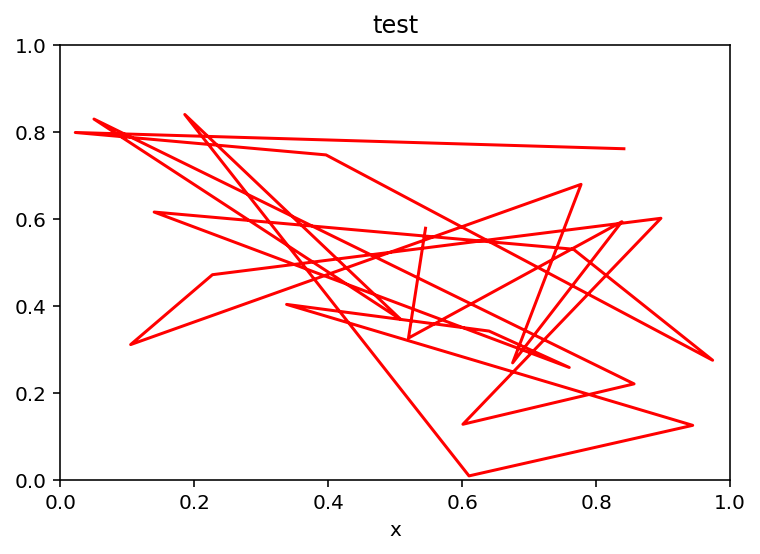

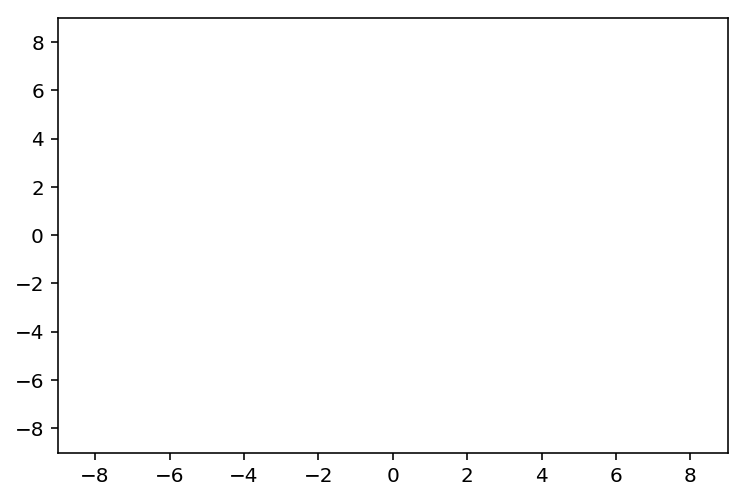

In [98]:
"""
=========================
Simple animation examples
=========================

This example contains two animations. The first is a random walk plot. The
second is an image animation.
"""

from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)

# HTML(line_ani.to_html5_video())

# To save the animation, use the command: line_ani.save('lines.mp4')

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
# To save this second animation with some metadata, use the following command:
# im_ani.save('im.mp4', metadata={'artist':'Guido'})

# plt.show()
HTML(line_ani.to_html5_video())

In [99]:
HTML(im_ani.to_jshtml())

In [ ]:
HTML(line_ani.to_html5_video())

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [ ]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [ ]:
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('im.mp4', metadata={'artist':'Guido'})

In [ ]:
((np.random.random(size=(2*19))-0.5)*20000).sum()/19

In [ ]:
np.random.normal(loc=0, scale=20000, size=(19)).sum()/19

In [ ]:
randos.sum()

In [ ]:
weather[weather['Station'] == 1]['Sunrise'].map(lambda string: int(string[0:2]) + int(string[3:4])/60)# + weather[weather['Station'] == 1]['Sunset'].map(lambda string: int(string))

In [ ]:
train.shape

In [ ]:
sns.pointplot(pd.to_datetime(train['Date']))

In [ ]:
iplot([{
    'x': spray.index,
    'y': spray[col],
    'name': col
}  for col in spray.columns])

In [ ]:
import plotly.figure_factory as ff

fips = ['06021', '06023', '06027',
        '06029', '06033', '06059',
        '06047', '06049', '06051',
        '06055', '06061']
values = range(len(fips))

fig = ff.create_choropleth(fips=fips, values=values)
iplot(fig)#, filename='choropleth of some cali counties - full usa scope')

In [100]:
import plotly.figure_factory as ff

import numpy as np
import pandas as pd

df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'Florida']

values = df_sample_r['TOT_POP'].tolist()
fips = df_sample_r['FIPS'].tolist()

endpts = list(np.mgrid[min(values):max(values):4j])
colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
              "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Florida'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
    plot_bgcolor='rgb(229,229,229)',
    paper_bgcolor='rgb(229,229,229)',
    legend_title='Population by County',
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
    exponent_format=True,
)
iplot(fig)#, filename='choropleth_florida')

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [ ]:
# import plotly.plotly as py
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df.head()

df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 5000

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['pop']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = dict(
        title = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
#             projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities, layout=layout )
iplot( fig, validate=False)#, filename='d3-bubble-map-populations' )

In [ ]:
df.head()

In [ ]:
iplot(dict(data=cities))

In [ ]:
"""
=========================
Simple animation examples
=========================

This example contains two animations. The first is a random walk plot. The
second is an image animation.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

fig1 = plt.figure()

data = np.random.rand(2, 25)
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)

# To save the animation, use the command: line_ani.save('lines.mp4')

fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
# To save this second animation with some metadata, use the following command:
# im_ani.save('im.mp4', metadata={'artist':'Guido'})

plt.show()

In [ ]:
cities[0]

https://plot.ly/~jackluo/2181/us-wind-turbine-dataset-animation-using/#/

In [ ]:
iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

In [ ]:
weather[weather['Date'] == '2014-10-02']

In [ ]:
test.tail()